# Ex-fuzzy para la detección y disminución de sesgos - Ejemplo 1: Supervivencia al desastre del titanic

Autores:


Raquel Fernandez Peralta - Slovak Academy of Sciences

Javier Fumanal Idocin - University of Essex, Yufe Fellow

En este ejemplo, utilizamos la base de datos de supervivientes del Titanic para entender como se entrena un clasificador basado en reglas borrosas y como se interpretan los resultados obtenidos. Además, para entender que aportan este tipo de algoritmos con respecto a otros, comparamos los resultados con una regresión logística y un Random Forest.

## 1. Instalación e importación de paquetes

Primero de todo instalamos la librería ex-fuzzy y descargamos las bases de datos que vamos a utilizar en este tutorial.

In [ ]:
!pip install git+https://github.com/Fuminides/ex-fuzzy.git
!git clone https://github.com/Fuminides/WorkshopIgualdad2025.git
!pip install lime

  Cloning https://github.com/Fuminides/ex-fuzzy.git to /tmp/pip-req-build-8xsnqsy9
  Running command git clone --filter=blob:none --quiet https://github.com/Fuminides/ex-fuzzy.git /tmp/pip-req-build-8xsnqsy9
  Resolved https://github.com/Fuminides/ex-fuzzy.git to commit 97baf4a1c6fa813481322d1fc8a60d075dfcf38a
  Preparing metadata (setup.py) ... done
fatal: destination path 'WorkshopIgualdad2025' already exists and is not an empty directory.


A continuación, importamos los demas paquetes de Python que vamos a utilizar en el tutorial.

In [ ]:
import pandas as pd
import numpy as np
from docutils.nodes import legend
import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools
import ex_fuzzy.vis_rules as vis_rules
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer

## 2. Algunas funciones que nos van a ser útiles

Para simplificar el tutorial, hemos implementado algunas funciones básicas que simplificaran algunas ejecuciones más adelante.

In [ ]:
def compute_metrics(y_test, y_pred, model_name="Model"):
    """
    Calcula y muestra métricas de evaluación de un modelo de clasificación,
    incluyendo una visualización de la matriz de confusión.

    Args:
        y_test: Valores reales
        y_pred: Predicciones del modelo
        model_name: Nombre del modelo para mostrar en los gráficos

    Returns:
        Diccionario con las métricas calculadas
    """
    # Calcular métricas
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Imprimir métricas con formato profesional
    print(f"\n=== {model_name} Evaluation Metrics ===")
    print(f"{'Accuracy:':<12} {metrics['Accuracy']:.4f}")
    print(f"{'F1 Score:':<12} {metrics['F1']:.4f}")
    print(f"{'Recall:':<12} {metrics['Recall']:.4f}")

    # Visualización de la matriz de confusión
    print("\n=== Confusion Matrix ===")

    # Configurar el estilo de seaborn
    sns.set(style="white")
    plt.figure(figsize=(5, 4))  # Reduced figure size from (8,6) to (5,4)

    # Crear heatmap de la matriz de confusión
    ax = sns.heatmap(metrics['Confusion Matrix'],
                     annot=True,
                     fmt="d",
                     cmap="Blues",
                     cbar=False,
                     annot_kws={"size": 12})  # Reduced annotation size from 14 to 12

    # Configuraciones adicionales del gráfico
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14, pad=15)  # Reduced font sizes
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    ax.xaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size
    ax.yaxis.set_ticklabels(['Negative', 'Positive'], fontsize=10)  # Reduced font size

    plt.tight_layout()
    plt.show()

    return metrics

def generar_mascara_categorica(X, verbose=True):
    """
    Genera una máscara que indica el número de clases únicas para cada columna categórica.

    Parámetros:
    -----------
    X : pandas.DataFrame
        DataFrame de entrada a analizar
    verbose : bool, opcional
        Si True, imprime información sobre las clases únicas (por defecto True)

    Retorna:
    --------
    numpy.ndarray
        Array donde cada posición representa una columna del DataFrame:
        - 0 para columnas no categóricas
        - Número de clases únicas para columnas categóricas
    """
    # Verificar que el input sea un DataFrame usando la forma recomendada
    if not hasattr(X, 'columns') or not hasattr(X, 'dtypes'):
        raise TypeError("El argumento X debe ser un pandas DataFrame o similar")

    # Inicializar la máscara con ceros
    categorical_mask = np.zeros(X.shape[1], dtype=int)

    # Iterar sobre cada columna
    for i, column in enumerate(X.columns):
        # Verificar si la columna es categórica usando métodos actualizados
        col_dtype = X[column].dtype
        if is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype):
            # Obtener clases únicas (maneja valores nulos adecuadamente)
            unique_classes = X[column].dropna().unique()
            categorical_mask[i] = len(unique_classes)

            # Mostrar información si verbose=True
            if verbose:
                # Manejar correctamente tipos numéricos en categorías
                try:
                    sorted_classes = sorted(unique_classes.tolist())
                except TypeError:
                    sorted_classes = unique_classes.tolist()
                print(f"Columna '{column}' - Clases únicas ({len(unique_classes)}): {sorted_classes}")

    return categorical_mask

def extract_rules_from_text(str_rules):
    """
    Extracts rule parts from a formatted rules text.

    Args:
        str_rules (str): String containing rules separated by newlines,
                        with possible headers and separators.

    Returns:
        list: A collection of cleaned rule parts (before 'WITH' keyword).
    """
    rule_collection = []
    consequent = -1
    for rule_cand in str_rules.splitlines():
        rule_cand = rule_cand.strip()  # Clean whitespace
        if rule_cand.startswith('Rules for consequent'):
            consequent = consequent +1
        else:
            if not (rule_cand.startswith('Rules for consequent') or rule_cand.startswith('------')) and rule_cand:
                # Split at 'WITH' and take the part before it
                rule_part = rule_cand.split('WITH')[0].strip()
                if rule_part:  # Ensure it's not empty after splitting
                    rule_part = rule_part + ' THEN ' + str(consequent)
                    rule_collection.append(rule_part)
    return rule_collection

## 3. Carga, exploracion y limpieza de los datos

Primero de todo, cargamos el dataset 'titanic.csv' que se puede encontrar en (https://www.kaggle.com/datasets/yasserh/titanic-dataset). Este dataset se utiliza frecuentemente para ejercicios de machine learning, específicamente para predecir qué pasajeros sobrevivieron al hundimiento del Titanic basándose en características como clase socioeconómica, edad, sexo y relaciones familiares.

In [ ]:
df = pd.read_csv('./WorkshopIgualdad2025/titanic.csv')
df.head()

,ID,Survived,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Mostramos información general del dataset, como tipos de datos y valores no nulos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        891 non-null    int64  
 1   Survived  891 non-null    int64  
 2   Class     891 non-null    int64  
 3   Name      891 non-null    object 
 4   Sex       891 non-null    object 
 5   Age       714 non-null    float64
 6   SibSp     891 non-null    int64  
 7   Parch     891 non-null    int64  
 8   Ticket    891 non-null    object 
 9   Fare      891 non-null    float64
 10  Cabin     204 non-null    object 
 11  Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Este dataset, tiene las siguientes variables:

- **PassengerId**: Número único de identificación para cada pasajero
- **Survived**: Indica si el pasajero sobrevivió (1) o no (0)
- **Pclass**: Clase del boleto (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase)
- **Name**: Nombre del pasajero
- **Sex**: Género del pasajero (male/female)
- **Age**: Edad del pasajero en años
- **SibSp**: Número de hermanos/cónyuges a bordo
- **Parch**: Número de padres/hijos a bordo
- **Ticket**: Número de boleto
- **Fare**: Tarifa pagada por el pasajero
- **Cabin**: Número de cabina
- **Embarked**: Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton)

Mostramos estadísticas descriptivas de las columnas numéricas del dataset.

In [ ]:
df.describe()

,ID,Survived,Class,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


A continuación, hacemos un gráfico de barras que muestra el porcentaje de supervivencia por género.

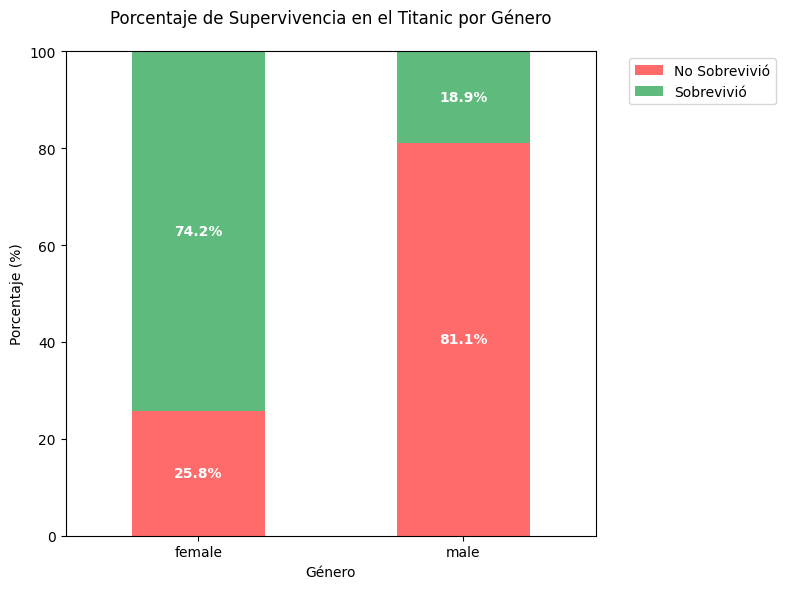

In [ ]:
# Calcular los porcentajes
survival_pct = df.groupby(['Sex', 'Survived']).size().unstack()
survival_pct = survival_pct.div(survival_pct.sum(axis=1), axis=0) * 100
# Crear el gráfico
ax = survival_pct.plot(kind='bar',
                      stacked=True,
                      color=['#ff6b6b', '#5fba7d'],
                      figsize=(8, 6))
plt.title('Porcentaje de Supervivencia en el Titanic por Género', pad=20)
plt.xlabel('Género')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)
plt.legend(['No Sobrevivió', 'Sobrevivió'], bbox_to_anchor=(1.05, 1))
plt.ylim(0, 100)
# Añadir etiquetas de porcentaje
for i, (gender, row) in enumerate(survival_pct.iterrows()):
    # Parte inferior (No sobrevivió)
    ax.text(i, row[0]/2, f"{row[0]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')

    # Parte superior (Sobrevivió)
    ax.text(i, row[0] + row[1]/2, f"{row[1]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold')
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Gráfico de barras que muestra el porcentaje de supervivencia por clase de pasaje.

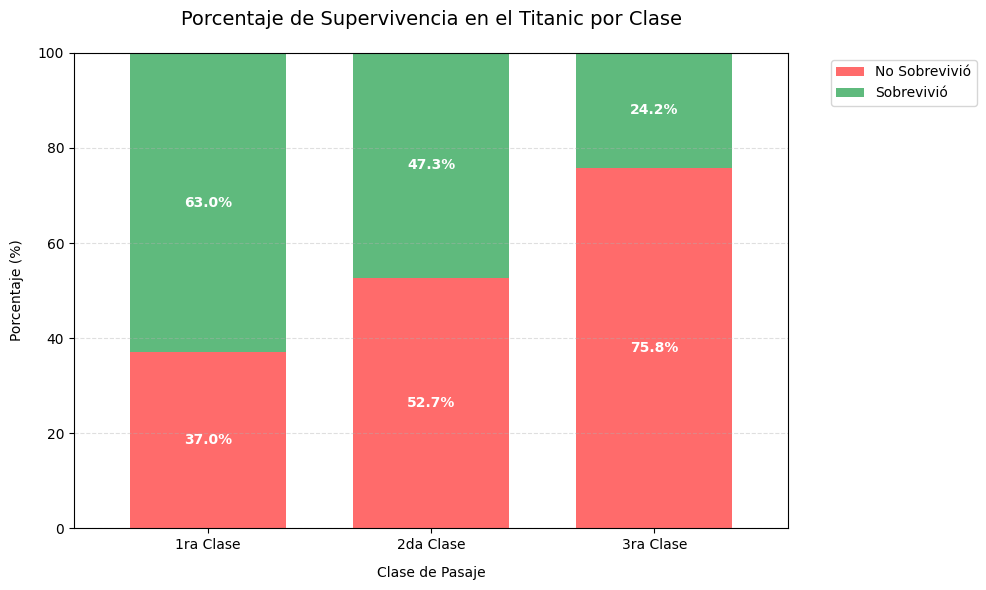

In [ ]:
# Calcular porcentajes por clase
class_survival = df.groupby(['Class', 'Survived']).size().unstack()
class_pct = class_survival.div(class_survival.sum(axis=1), axis=0) * 100

# Mapear nombres de clase para mejor visualización
class_names = {1: '1ra Clase', 2: '2da Clase', 3: '3ra Clase'}
class_pct.index = class_pct.index.map(class_names)

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#ff6b6b', '#5fba7d']  # Rojo para no sobrevivientes, verde para sobrevivientes

# Gráfico de barras apiladas
class_pct.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.7)

# Configuración del gráfico
plt.title('Porcentaje de Supervivencia en el Titanic por Clase', pad=20, fontsize=14)
plt.xlabel('Clase de Pasaje', labelpad=10)
plt.ylabel('Porcentaje (%)', labelpad=10)
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Leyenda personalizada
handles, labels = ax.get_legend_handles_labels()
plt.legend(['No Sobrevivió', 'Sobrevivió'], bbox_to_anchor=(1.05, 1))

# Añadir etiquetas de porcentaje
for i, (cls, row) in enumerate(class_pct.iterrows()):
    # Segmento inferior (No sobrevivió)
    ax.text(i, row[0]/2, f"{row[0]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)

    # Segmento superior (Sobrevivió)
    ax.text(i, row[0] + row[1]/2, f"{row[1]:.1f}%",
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# Ajustes finales
plt.tight_layout()
plt.show()

Observamos si tenemos datos faltantes. A continuación, eliminamos las variables no significativas para clasificar y optamos por eliminar las filas que tengan algún dato faltante (también se podrían imputar https://scikit-learn.org/stable/modules/impute.html).

In [ ]:
df2 = df.copy()

In [ ]:
missing_values = df2.isnull().sum()
print(missing_values[missing_values > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [ ]:
df2 = df2.dropna(subset=['Age', 'Embarked'])

In [ ]:
X = df2.drop(columns=['Survived','ID','Name','Ticket','Cabin'])
y = df2['Survived'].to_numpy()

Asignamos a cada variable el tipo que le corresponde. Este paso es necesario para una correcta codificación de las variables categóricas.

In [ ]:
X.dtypes

,0
Class,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Embarked,object


In [ ]:
X['Class'] = df2['Class'].astype(object)

## 4. Entrenamos un clasificador basado en reglas con ex-fuzzy


Primero de todo, separamos la base de datos en conjunto de entrenamiento y validación.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Ahora, creamos un vector que nos indique qué variables son categóricas y cuántas clases tiene dicha variable.

In [ ]:
categorical_mask = generar_mascara_categorica(X,verbose=True)

Columna 'Class' - Clases únicas (3): [1, 2, 3]
Columna 'Sex' - Clases únicas (2): ['female', 'male']
Columna 'Embarked' - Clases únicas (3): ['C', 'Q', 'S']


A continuación, seleccionamos el tipo de conjuntos borrosos a utilizar y el número de particiones a utilizar para las variables numéricas. Con estos parámetros podemos crear una partición borrosa para cada variable. Concretamente, la función *construct_partitions* utiliza los cuantiles de los datos $(0,0.2,0.4,0.6,0.8,1)$.

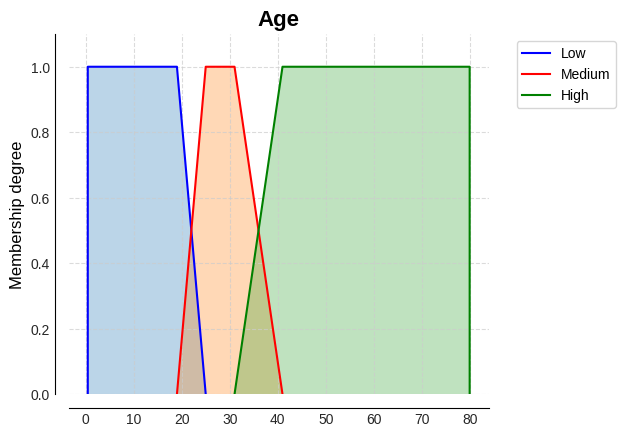

In [ ]:
fz_type_studied = fs.FUZZY_SETS.t1
n_linguistic_variables = 3
precomputed_partitions = utils.construct_partitions(X, fz_type_studied, n_partitions=n_linguistic_variables, categorical_mask=categorical_mask)
vis_rules.plot_fuzzy_variable(precomputed_partitions[2])

Ahora, definimos y entrenamos el clasficador basado en reglas borrosas. Para entrenarlo, podemos elegir entre diferentes parámetros vinculados al tipo de base en reglas que queremos obtener y los parámetros vinculados a la optimización por un algoritmo genético.

In [ ]:
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=10, # Número máximo de reglas
                                           nAnts=3, # Número máximo de variables que pueden aparecen en el antecedent de las reglas
                                           fuzzy_type=fz_type_studied, # Tipo de conjunto borroso a utilizar
                                           tolerance=0.0, # Tolerancia mínima a considerar. Podemos aumentar este límite si no queremos obtener reglas con un mínimo de calidad.
                                           n_linguistic_variables=n_linguistic_variables, # Número de etiquetas linguisticas que queremos en la fuzzificación de las variables numéricas.
                                           verbose = True, # Si True, se imprime por pantalla los resultados obtenidos luego de cada iteración.
                                           linguistic_variables=None, #Si indicamos None se inicializan los pesos con los quantiles y luego se optimizan para obtener una mejor clasificación. Si indicamos una partición concreta entonces esta quedará fija.
                                           categorical_mask = categorical_mask, # Máscara de variables categóricas.
                                           ds_mode=1, # El clasificador tiene 3 modos diferentes según los pesos que queramos asignar a cada regla -> Si se establece en 0, se utilizan las puntuaciones de dominancia como pesos; si se establece en 1, todos los pesos se configuran en 1; y si se establece en 2, se ignorarán las puntuaciones de dominancia y los pesos se establecerán mediante la optimización genética.
                                           allow_unknown=False # Si True, permite cada regla devolver -1 para indicar que la clase a asignar es desconocida.
                                            )
fl_classifier.fit(X_train,
                  y_train,
                  n_gen=10, # Número de iteraciones
                  pop_size=30, # Número de individuos a considerar en cada iteración
                  random_state=42)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  0.9394690183 |  0.4491840831
     2 |       60 |  0.7465595688 |  0.4491840831
     3 |       90 |  0.6069932751 |  0.4491840831
     4 |      120 |  0.4954440160 |  0.4432201446
     5 |      150 |  0.4485876893 |  0.4432201446
     6 |      180 |  0.4473011227 |  0.4404067782
     7 |      210 |  0.4446229705 |  0.4404067782
     8 |      240 |  0.4427512502 |  0.4404067782
     9 |      270 |  0.4420010192 |  0.4404067782
    10 |      300 |  0.4404067782 |  0.4404067782


Utilizando la función *get_rulebase* podemos guardar la base de reglas obtenida y con *eval_fuzzy_model* obtenemos una resumen de la performance obtenida así como la visualización de las reglas, los pesos, accuracy y dominancia. También nos permite visualizar tanto la partición borrosa como la base de reglas.

In [ ]:
rule_base = fl_classifier.get_rulebase()
fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test,
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=True)

------------
ACCURACY
Train performance: 0.7882599580712788
Test performance: 0.7361702127659574
------------
MATTHEW CORRCOEF
Train performance: 0.5595932217585016
Test performance: 0.456218399207354
------------
Rules for consequent: 0
----------------
IF Fare IS Medium WITH DS 0.0010861738470407643, ACC 0.8504273504273504, WGHT 1.0
IF Sex IS male AND Parch IS Medium WITH DS 0.027157710699696056, ACC 0.7346938775510204, WGHT 1.0

Rules for consequent: 1
----------------
IF Class IS 1 AND SibSp IS Medium WITH DS 0.008101456504492208, ACC 0.5294117647058824, WGHT 1.0
IF Sex IS female WITH DS 0.10881689806574107, ACC 0.7572254335260116, WGHT 1.0
IF SibSp IS Medium AND Embarked IS C WITH DS 0.0069263522367318435, ACC 0.25, WGHT 1.0




Si queremos más métricas podemos hacerlo como es usual, en este tutorial utilizamos la función *compute_metrics* definida más arriba.


=== Model Evaluation Metrics ===
Accuracy:    0.7362
F1 Score:    0.6804
Recall:      0.6667

=== Confusion Matrix ===


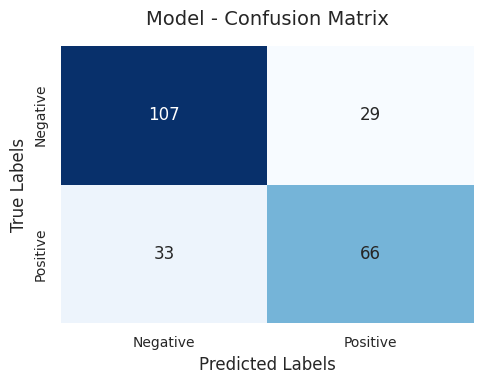

In [ ]:
y_pred = fl_evaluator.fl_classifier.predict(X_test)
metrics = compute_metrics(y_test, y_pred)

### 4.1 Explicación por instancia.

En esta sección, utilizaremos la base de reglas obtenida con el algoritmo para dar una explicación de la clasificación hecha para cada instancia.

Primero de todo, extraemos cada regla como un string de texto.

In [ ]:
rule_collection = extract_rules_from_text(str_rules)
rule_collection

['IF Fare IS Medium THEN 0',
 'IF Sex IS male AND Parch IS Medium THEN 0',
 'IF Class IS 1 AND SibSp IS Medium THEN 1',
 'IF Sex IS female THEN 1',
 'IF SibSp IS Medium AND Embarked IS C THEN 1']

Ahora, podemos usar la función *explainable_predict* para extraer la clase asginada a cada ejemplo, la regla utilizada para decidir dicha clase y el nivel de verdad correspondiente. Notad que para este paso hemos considerado todo el dataset y no solo el conjunto de validación.

In [ ]:
explainable_predict = fl_classifier.explainable_predict(X)
class_assigned = explainable_predict[0]
fired_rules = explainable_predict[1]
membership_degree = explainable_predict[2]

In [ ]:
results_instance = pd.DataFrame({
    'instance': df2['Name'].values.ravel(),  #
    'sex': df2['Sex'].values.ravel(),  #
    'survived': df2['Survived'].values.ravel(),  #
    'fired_Rule': [rule_collection[i] for i in np.array(fired_rules).ravel()],
    'consequent': np.array(class_assigned).ravel(),
    'membership': np.array(membership_degree).ravel()
})
results_instance.head(10)

,instance,sex,survived,fired_Rule,consequent,membership
0,"Braund, Mr. Owen Harris",male,0,IF Fare IS Medium THEN 0,0.0,0.000000
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,IF Sex IS female THEN 1,1.0,1.000000
2,"Heikkinen, Miss. Laina",female,1,IF Sex IS female THEN 1,1.0,1.000000
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,IF Sex IS female THEN 1,1.0,1.000000
4,"Allen, Mr. William Henry",male,0,IF Fare IS Medium THEN 0,0.0,0.000000
5,"McCarthy, Mr. Timothy J",male,0,IF Fare IS Medium THEN 0,0.0,0.000000
6,"Palsson, Master. Gosta Leonard",male,0,IF Sex IS male AND Parch IS Medium THEN 0,0.0,0.423729
7,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,1,IF Sex IS female THEN 1,1.0,1.000000
8,"Nasser, Mrs. Nicholas (Adele Achem)",female,1,IF Sex IS female THEN 1,1.0,1.000000
9,"Sandstrom, Miss. Marguerite Rut",female,1,IF Sex IS female THEN 1,1.0,1.000000


Si además queremos entender para cada ejemplo porqué a ganado cada regla podemos utilizar la función 'predict_proba' para obtener el nivel de verdad de cada regla para cada ejemplo.

In [ ]:
rule_memberships = fl_evaluator.fl_classifier.predict_proba(X)
results_dict = {'instance': df2['Name'].values.ravel()}
for i, rule in enumerate(rule_collection):
    results_dict[rule] = rule_memberships[:, i].ravel()
results_dict['rule_selected'] = [rule_collection[i] for i in np.array(fired_rules).ravel()]
results_instance_2 = pd.DataFrame(results_dict)
results_instance_2

,instance,IF Fare IS Medium THEN 0,IF Sex IS male AND Parch IS Medium THEN 0,IF Class IS 1 AND SibSp IS Medium THEN 1,IF Sex IS female THEN 1,IF SibSp IS Medium AND Embarked IS C THEN 1,rule_selected
0,"Braund, Mr. Owen Harris",0.0,0.0,0.000000,0.0,0.000000,IF Fare IS Medium THEN 0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,0.0,0.262295,1.0,0.262295,IF Sex IS female THEN 1
2,"Heikkinen, Miss. Laina",0.0,0.0,0.000000,1.0,0.000000,IF Sex IS female THEN 1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,0.0,0.262295,1.0,0.000000,IF Sex IS female THEN 1
4,"Allen, Mr. William Henry",0.0,0.0,0.000000,0.0,0.000000,IF Fare IS Medium THEN 0
...,...,...,...,...,...,...,...
707,"Rice, Mrs. William (Margaret Norton)",0.0,0.0,0.000000,1.0,0.000000,IF Sex IS female THEN 1
708,"Montvila, Rev. Juozas",0.0,0.0,0.000000,0.0,0.000000,IF Fare IS Medium THEN 0
709,"Graham, Miss. Margaret Edith",0.0,0.0,0.000000,1.0,0.000000,IF Sex IS female THEN 1
710,"Behr, Mr. Karl Howell",0.0,0.0,0.000000,0.0,0.000000,IF Fare IS Medium THEN 0


## 5. Comparación con otros clasificadores

En esta sección, entrenamos una regresión logística y un random forest para comparar los resultados con el clasificador basado en reglas y la explicación que puede aportar cada algoritmo.

### 5.1 Regresión logística

Definimos una función para entrenar y evaluar un modelo de regresión logística, que es un modelo lineal más simple.

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test, show_feature_importance=True):
    """
    Simplified logistic regression with one-hot encoding for categorical features.
    Returns model, metrics, and feature importance.
    """
    # Identify categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

    # Train model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    metrics = compute_metrics(y_test,y_pred)

    # Feature importance
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.named_steps['classifier'].coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)

    if show_feature_importance:
        plt.figure(figsize=(10, 6))
        coef_df.plot.barh(x='Feature', y='Coefficient', color='skyblue',legend=False)
        plt.title('LR Feature Importance (Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.axvline(x=0, color='k', linestyle='--')
        plt.tight_layout()
        plt.show()

    return model, metrics, coef_df

Entrenamos la regresión logística y visualizamos la importancia de las características.


=== Model Evaluation Metrics ===
Accuracy:    0.7574
F1 Score:    0.7047
Recall:      0.6869

=== Confusion Matrix ===


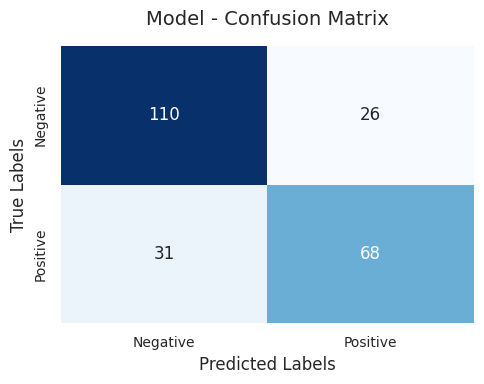

<Figure size 1000x600 with 0 Axes>

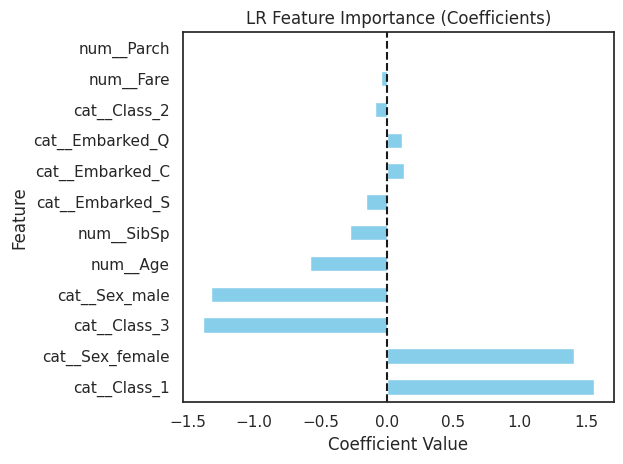

In [ ]:
model, metrics, coef_df = train_logistic_regression(X_train, y_train, X_test, y_test)

### 5.2 Random Forest

También entrenamos un modelo de Random Forest que suele tener mejor rendimiento pero es menos interpretable que la regresión logística o los modelos basados en reglas difusas.

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test, show_feature_importance=True, **rf_params):

    # Identify categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

    # Train model with default or provided parameters
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**rf_params))
    ])
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    metrics = compute_metrics(y_test, y_pred)

    # Feature importance
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    importances = model.named_steps['classifier'].feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    if show_feature_importance:
        plt.figure(figsize=(10, 6))
        importance_df.plot.barh(x='Feature', y='Importance', color='skyblue', legend=False)
        plt.title('Random Forest Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

    return model, metrics, importance_df

Entrenamos el Random Forest y visualizamos la importancia de las características.


=== Model Evaluation Metrics ===
Accuracy:    0.7532
F1 Score:    0.6947
Recall:      0.6667

=== Confusion Matrix ===


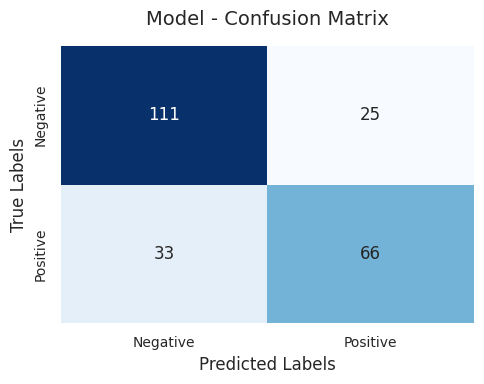

<Figure size 1000x600 with 0 Axes>

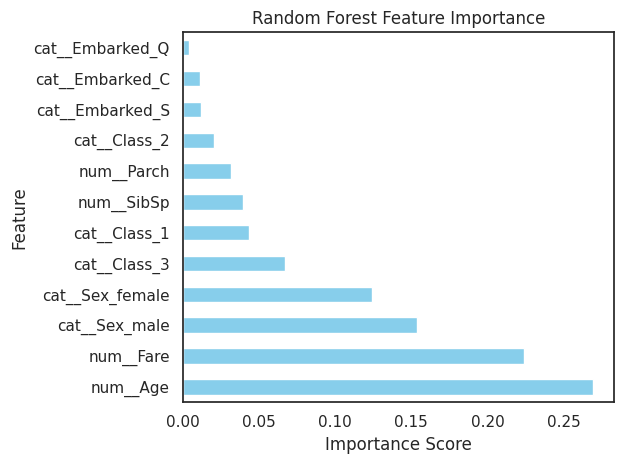

In [ ]:
model, metrics, coef_df = train_random_forest(X_train, y_train, X_test, y_test)

### 4.3 Utilizando un explainer

Como se puede ver, en algoritmos no explicativos como el Random Forest no podemos ver si la influencia de cada variabe es positiva o negativa. Por lo tanto, en este tipo de algoritmos necesitamos utilizar un algoritmo que nos aporte tal explicación. Por ejemplo, podemos utilizar LIME (https://github.com/marcotcr/lime) para dar una explicación de la clasificación hecha por el Random Forest en cada instancia.

In [ ]:
# Transform X_test for LIME
X_transformed = model.named_steps['preprocessor'].transform(X)
X_transformed = model.named_steps['preprocessor'].transform(X)

# LIME explanation
explainer = LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=model.named_steps['preprocessor'].get_feature_names_out(),
    class_names=np.unique(y_train).astype(str),
    mode='classification',
    discretize_continuous=True
)

In [ ]:
instance_index = 10
instance_to_explain = X.iloc[instance_index]
instance_transformed = X_transformed[instance_index]

exp = explainer.explain_instance(
    data_row=instance_transformed,
    predict_fn=model.named_steps['classifier'].predict_proba,
    num_features=6
)

In [ ]:
exp.as_list()

[('cat__Sex_male <= 0.00', 0.2395899875953779),
 ('0.00 < cat__Sex_female <= 1.00', 0.20477000064570786),
 ('cat__Class_3 <= 0.00', 0.1450705556686086),
 ('0.00 < cat__Class_1 <= 1.00', 0.11493048828424869),
 ('num__Age > 0.56', -0.07381543733584858),
 ('cat__Embarked_C <= 0.00', -0.019030080249343682)]

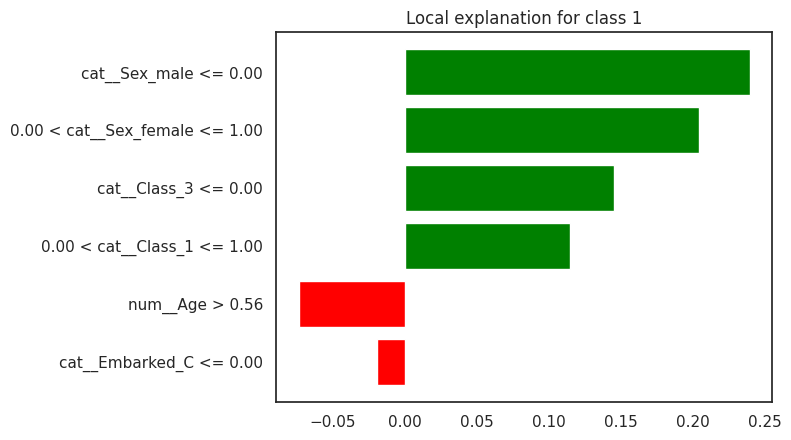

In [ ]:
fig = exp.as_pyplot_figure()